Start by loading data and converting the columns from questions to names. Shuffle rows for privacy.

In [11]:
import pandas as pd
import scipy.stats as sp

df = pd.read_csv('responses2.tsv',
                 sep = '\t')

In [12]:
print df.columns

Index([u'Timestamp', u'How old are you?', u'What grade are you in?',
       u'What do you want to do when you grow up? (probably forgetting things, feel free to liberally use the "Other" box)',
       u'Have you been in any relationships (>1 month long) in high school?',
       u'How many >1 month relationships have you been in while in high school? (yes, I know I can infer the answer to the previous question from the data for this one, but I am adding this question later and therefore cannot edit the previous one)',
       u'What is your weighted GPA? (can check on Harker transcript, or can just give approximate value, or calculate here, courtesy of Neeraj: tiny.cc/gpa)',
       u'What is your unweighted GPA? (4.0 is maximum; can just give approximate value, or calculate here: tiny.cc/gpa)',
       u'What's your favorite subject?',
       u'Broadly speaking, do you feel stressed?',
       u'What classes are you taking? Please list using separate lines per class.',
       u'What ethnic

In [13]:
df.columns = ['time', 'age', 'grade', 'occupation',
              'relation_binary', 'relation_num', 'wgpa', 'ugpa',
              'favsubj', 'stress', 'classes', 'race', 
              'honors', 'drive', 'aps', 'iq', 'hobby',
              'music', 'college', 'gender', 'sleep',
              'mtgs', 'teacher1', 'teacher2']

In [28]:
df = df.sample(frac=1).reset_index(drop=True)

First comparison - weighted GPA in stressed groups vs. non-stressed groups

In [30]:
print len(df['wgpa'])

49


In [27]:
import numpy as np

nonNan = np.logical_not(np.isnan(df['wgpa']))

# stressGpas = df['wgpa'][df['stress'] == 'Yes']
# unstressGpas = df['wgpa'][df['stress'] == 'No']
stressGpas = df['wgpa'][np.logical_and(df['stress'] == 'Yes', nonNan)]
unstressGpas = df['wgpa'][np.logical_and(df['stress'] == 'No', nonNan)]

print len(stressGpas)
print len(unstressGpas)

print np.nanmean(stressGpas)
print np.nanmean(unstressGpas)
print sp.ttest_ind(stressGpas, unstressGpas)
print sp.mannwhitneyu(stressGpas, unstressGpas)

17
21
4.10588235294
4.39428571429
Ttest_indResult(statistic=-3.3081323265538001, pvalue=0.0021385305321256591)
MannwhitneyuResult(statistic=77.5, pvalue=0.0015633761704365444)


The p-value appears pretty significant (probability of these data if there were no relationship = 0.002) that people who report not being stressed have higher GPA. thi

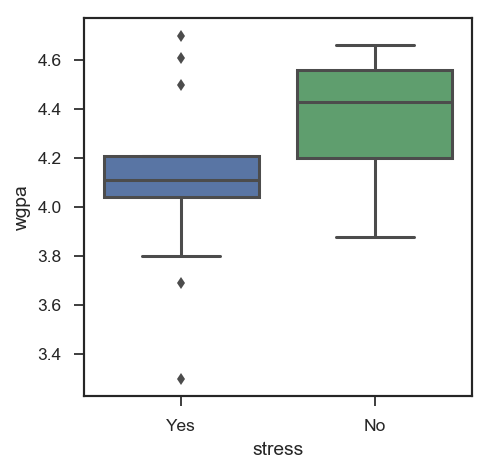

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style = 'ticks')

plt.figure(figsize=(4,4), dpi=125)

sns.boxplot(data = df, y = 'wgpa', x = 'stress')

plt.show()